# Part 4: Statistical Analysis

This notebook handles:
- Descriptive statistics of returns
- Annualized metrics (returns, volatility, Sharpe ratio)
- Rolling volatility analysis


## 4.1 Setup


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 8)

pd.set_option('display.float_format', '{:.4f}'.format)


✓ Libraries imported successfully!


## 4.2 Load Data


In [ ]:
%store -r returns_df
%store -r tech_stocks
%store -r finance_stocks
%store -r all_tickers

if 'returns_df' not in locals():
    processed_dir = Path.cwd().parent / 'data' / 'processed'
    returns_df = pd.read_csv(processed_dir / 'daily_returns.csv', index_col=0, parse_dates=True)
    tech_stocks = ['AAPL', 'MSFT', 'GOOGL']
    finance_stocks = ['JPM', 'BAC', 'GS']
    all_tickers = tech_stocks + finance_stocks
    print("✓ Data loaded from CSV files")
else:
    print("✓ Data loaded from previous notebook")

print(f"✓ Returns shape: {returns_df.shape}")


✓ Data loaded from previous notebook
✓ Returns shape: (1482, 6)


## 4.3 Descriptive Statistics


In [ ]:
stats_dict = {
    'Mean': returns_df.mean(),
    'Median': returns_df.median(),
    'Std Dev': returns_df.std(),
    'Min': returns_df.min(),
    'Max': returns_df.max(),
    'Skewness': returns_df.skew(),
    'Kurtosis': returns_df.kurtosis(),
    '25th Percentile': returns_df.quantile(0.25),
    '75th Percentile': returns_df.quantile(0.75)
}

stats_df = pd.DataFrame(stats_dict).T

display(stats_df)


Descriptive Statistics of Daily Returns


,AAPL,MSFT,GOOGL,JPM,BAC,GS
Mean,0.0011,0.0009,0.0013,0.0008,0.0006,0.0011
Median,0.0011,0.0010,0.0018,0.0010,0.0004,0.0007
Std Dev,0.0202,0.0187,0.0206,0.0198,0.0218,0.0208
Min,-0.1286,-0.1474,-0.1163,-0.1496,-0.1540,-0.1271
Max,0.1533,0.1422,0.1022,0.1801,0.1780,0.1758
Skewness,0.2796,0.1092,0.0039,0.3707,0.3166,0.2986
Kurtosis,6.6715,7.4749,3.5741,12.9544,10.6785,10.0856
25th Percentile,-0.0083,-0.0079,-0.0094,-0.0080,-0.0098,-0.0093
75th Percentile,0.0116,0.0105,0.0116,0.0099,0.0108,0.0115



Interpretation:
• Skewness close to 0 indicates symmetric distribution
• Positive kurtosis indicates heavier tails than normal distribution
• Higher std dev indicates higher volatility


## 4.4 Annualized Metrics


In [ ]:
trading_days = 252

annualized_returns = returns_df.mean() * trading_days
annualized_volatility = returns_df.std() * np.sqrt(trading_days)

sharpe_ratio = annualized_returns / annualized_volatility

metrics_df = pd.DataFrame({
    'Annual Return': annualized_returns,
    'Annual Volatility': annualized_volatility,
    'Sharpe Ratio': sharpe_ratio
})

display(metrics_df.sort_values('Sharpe Ratio', ascending=False))


%store annualized_returns
%store annualized_volatility
%store sharpe_ratio
%store metrics_df


Annualized Metrics (252 trading days)


,Annual Return,Annual Volatility,Sharpe Ratio
GOOGL,0.3160,0.3263,0.9686
AAPL,0.2786,0.3204,0.8694
GS,0.2844,0.3295,0.8632
MSFT,0.2370,0.2971,0.7977
JPM,0.2047,0.3148,0.6503
BAC,0.1480,0.3465,0.4273



Key Insights:
• Best Sharpe Ratio: GOOGL (0.9686)
• Highest Return: GOOGL (31.60%)
• Lowest Volatility: MSFT (29.71%)
Stored 'annualized_returns' (Series)
Stored 'annualized_volatility' (Series)
Stored 'sharpe_ratio' (Series)
Stored 'metrics_df' (DataFrame)


## 4.5 Sector Comparison


Sector Average Metrics


,Technology,Financial
Annual Return,0.2772,0.2124
Annual Volatility,0.3146,0.3302
Sharpe Ratio,0.8786,0.6469


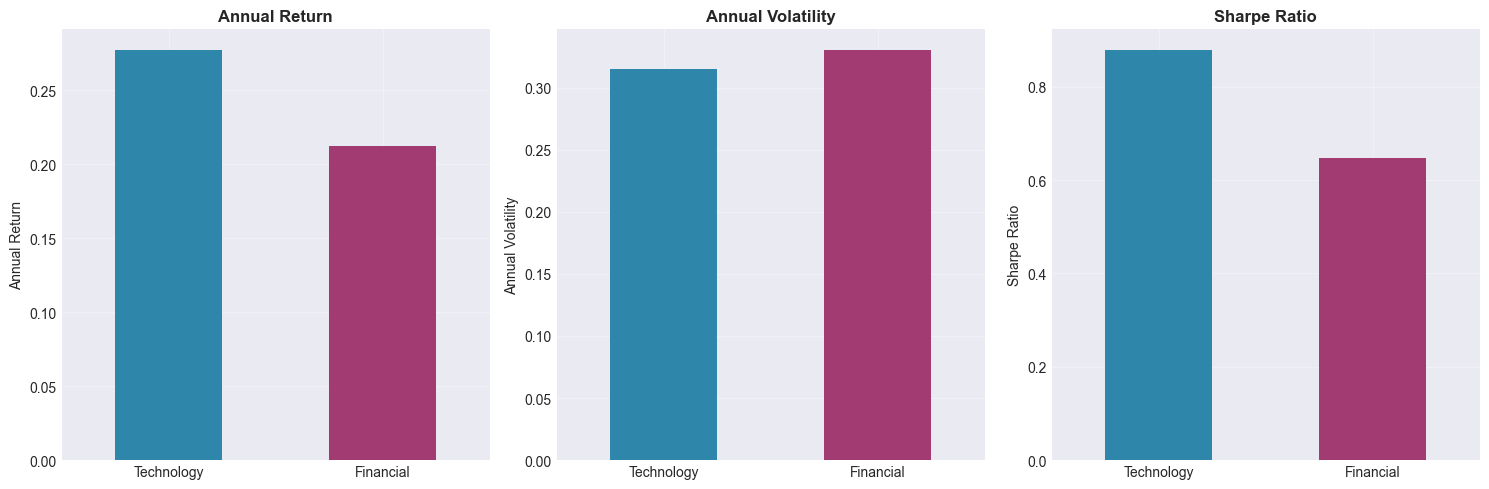


✓ Technology stocks generally show higher returns but also higher volatility
✓ Sharpe ratio indicates risk-adjusted performance


In [ ]:
tech_metrics = metrics_df.loc[tech_stocks].mean()
finance_metrics = metrics_df.loc[finance_stocks].mean()

sector_comparison = pd.DataFrame({
    'Technology': tech_metrics,
    'Financial': finance_metrics
})

display(sector_comparison)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_to_plot = ['Annual Return', 'Annual Volatility', 'Sharpe Ratio']
for idx, metric in enumerate(metrics_to_plot):
    sector_comparison.loc[metric].plot(kind='bar', ax=axes[idx], color=['#2E86AB', '#A23B72'])
    axes[idx].set_title(metric, fontweight='bold')
    axes[idx].set_ylabel(metric)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()


## 4.6 Rolling Volatility Analysis


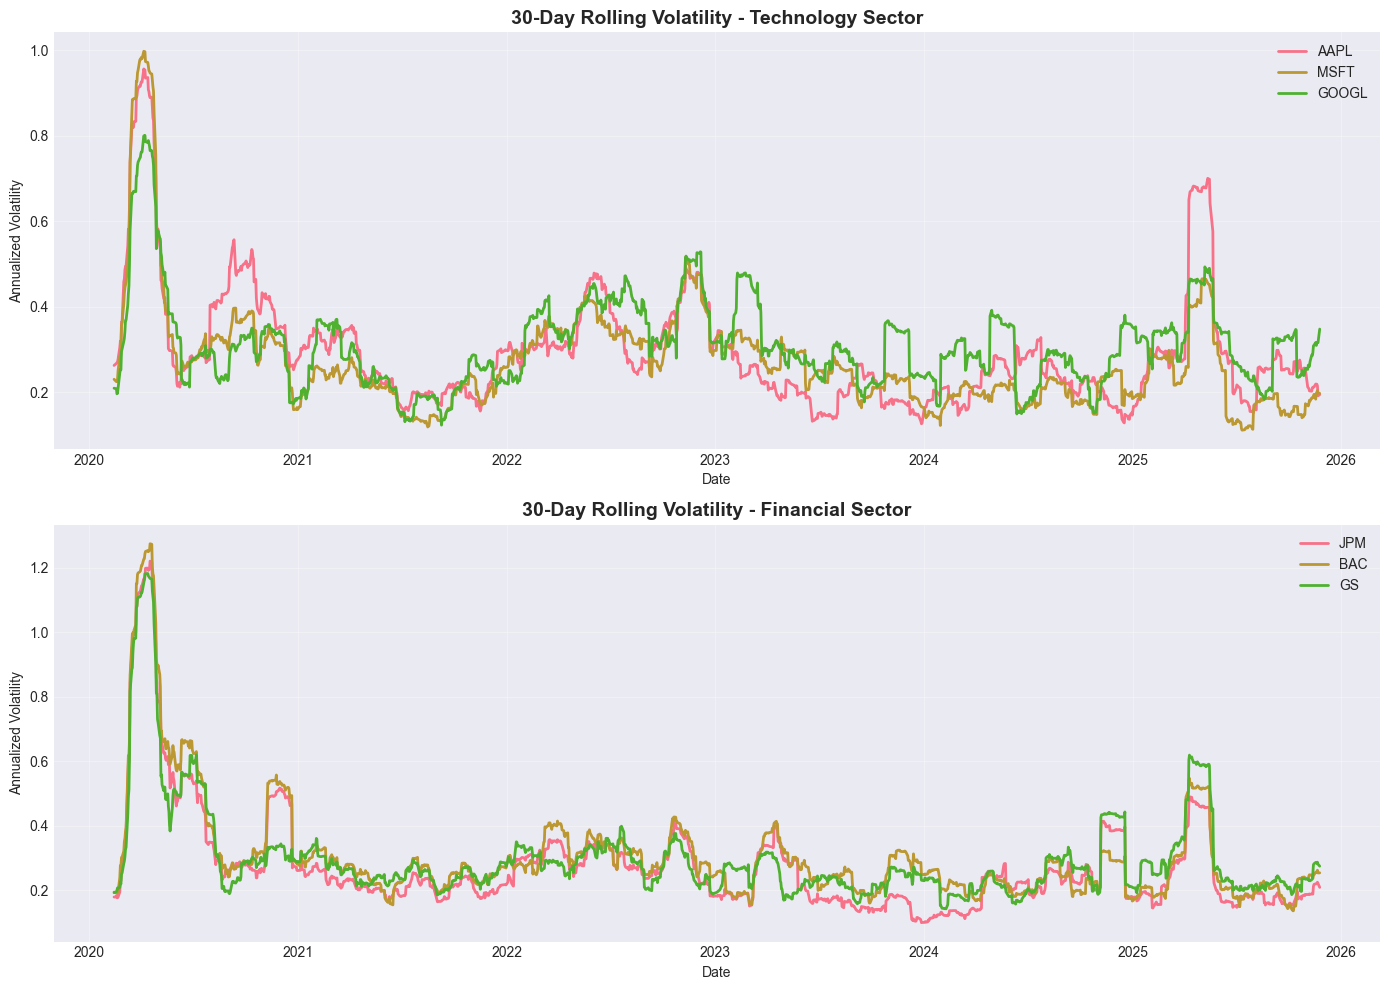

✓ Volatility spikes visible during market stress periods (e.g., COVID-19 pandemic)
✓ Technology stocks show more volatile patterns than financial stocks
Stored 'rolling_volatility' (DataFrame)


In [ ]:
window = 30
rolling_volatility = returns_df.rolling(window=window).std() * np.sqrt(trading_days)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

for ticker in tech_stocks:
    axes[0].plot(rolling_volatility.index, rolling_volatility[ticker], label=ticker, linewidth=2)

axes[0].set_title(f'{window}-Day Rolling Volatility - Technology Sector', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Annualized Volatility')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for ticker in finance_stocks:
    axes[1].plot(rolling_volatility.index, rolling_volatility[ticker], label=ticker, linewidth=2)

axes[1].set_title(f'{window}-Day Rolling Volatility - Financial Sector', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Annualized Volatility')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

%store rolling_volatility


## 4.7 Extreme Returns Analysis


In [ ]:
print("Best Single Day Returns")
best_days = returns_df.max().sort_values(ascending=False)
for ticker, return_val in best_days.items():
    best_date = returns_df[ticker].idxmax()
    print(f"{ticker:6s}: {return_val:+7.2%} on {best_date.date()}")

print("Worst Single Day Returns")
worst_days = returns_df.min().sort_values()
for ticker, return_val in worst_days.items():
    worst_date = returns_df[ticker].idxmin()
    print(f"{ticker:6s}: {return_val:+7.2%} on {worst_date.date()}")


Best Single Day Returns
JPM   : +18.01% on 2020-03-13
BAC   : +17.80% on 2020-03-13
GS    : +17.58% on 2020-03-13
AAPL  : +15.33% on 2025-04-09
MSFT  : +14.22% on 2020-03-13
GOOGL : +10.22% on 2024-04-26

Worst Single Day Returns
BAC   : -15.40% on 2020-03-16
JPM   : -14.96% on 2020-03-16
MSFT  : -14.74% on 2020-03-16
AAPL  : -12.86% on 2020-03-16
GS    : -12.71% on 2020-03-16
GOOGL : -11.63% on 2020-03-16
